In [4]:
import numpy as np
import math
import matplotlib.pylab as plt
from scipy.stats import norm
import pandas as pd
import json as js
#from yahoo_finance import Share
import datetime as dt


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
def randgen(pr, N=1): 
    L = len(pr)
    return int(np.random.choice(range(L), size=N, replace=True, p=pr))

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    idx = np.where(l_star == float('-inf'))
    l_star[idx] = -1e32
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P

def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def normpdf(x, mean, sd):
        var = float(sd)**2
        pi = 3.1415926
        denom = (2*pi*var)**.5
        num = math.exp(-(float(x)-float(mean))**2/(2*var))
        return num/denom

In [3]:


class HMM(object):
    def __init__(self, pi, A, B_avg, B_sd):
        # p(x_0)
        self.pi = pi
        # p(x_k|x_{k-1})
        self.A = A
        # p(y_k|x_{k})
        self.B_avg = B_avg
        self.B_sd = B_sd
        
        
        # Number of possible latent states at each time
        self.S = pi.shape[0]
        
        self.logB_avg = np.log(self.B_avg)
        self.logB_sd = np.log(self.B_sd)

        self.logA = np.log(self.A)
        self.logpi = np.log(self.pi)
    
    def set_param(self, pi=None, A=None, B=None):
        if pi is not None:
            self.pi = pi
            self.logpi = np.log(self.pi)

        if A is not None:
            self.A = A
            self.logA = np.log(self.A)

        if B_avg is not None:
            self.B_avg = B_avg
            self.logB_avg = np.log(self.B_avg)
            
        if B_sd is not None:
            self.B_sd = B_sd
            self.logB_sd = np.log(self.B_sd)

    @classmethod
    def from_random_parameters(cls, S=3):
        A = np.random.dirichlet(0.7*np.ones(S),S).T
        B_avg = (3*np.random.rand(1,S)).reshape(S)
        B_sd = (np.random.rand(1,S)).reshape(S)
        pi = np.random.dirichlet(0.7*np.ones(S)).T
        return cls(pi, A, B_avg, B_sd)
        
    def __str__(self):
        s = "Prior:\n" + str(self.pi) + "\nA:\n" + str(self.A) + "\nB_avd:\n" + str(self.B_avg)+ "\nB_sd:\n" + str(self.B_sd)
        return s
    
    def __repr__(self):
        s = self.__str__()
        return s
    
    def log_prob_list(self, y):
        l = []
        for i in range(self.S):
            l.append(normpdf(y,self.B_avg[i],self.B_sd[i]))
        return np.log(l)

    def predict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(self.A,np.exp(lp-lstar)))

    def postdict(self, lp):
        lstar = np.max(lp)
        return lstar + np.log(np.dot(np.exp(lp-lstar), self.A))

    def predict_maxm(self, lp):
        return np.max(self.logA + lp, axis=1)

    def postdict_maxm(self, lp):
        return np.max(self.logA.T + lp, axis=1)

    def update(self, y, lp):
        return self.log_prob_list(y) + lp if not np.isnan(y) else lp
    
    

        

    def generate_sequence(self, T=10):
    # T: Number of steps

        x = np.zeros(T, int)
        y = np.zeros(T, float)

        for t in range(T):
            if t==0:
                x[t] = randgen(self.pi)
            else:
                x[t] = randgen(self.A[:,x[t-1]])  
            
            y[t] =self.B_sd[x[t]] * np.random.randn() + self.B_avg[x[t]]
    
        return y, x

    def forward(self, y, maxm=False):
        T = len(y)
        
        # Forward Pass

        # Python indices start from zero so
        # log \alpha_{k|k} will be in log_alpha[:,k-1]
        # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]
        log_alpha  = np.zeros((self.S, T))
        log_alpha_pred = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred[:,0] = self.logpi
            else:
                if maxm:
                    log_alpha_pred[:,k] = self.predict_maxm(log_alpha[:,k-1])
                else:
                    log_alpha_pred[:,k] = self.predict(log_alpha[:,k-1])

                
            log_alpha[:,k] = self.update(y[k], log_alpha_pred[:,k])
            
        return log_alpha, log_alpha_pred
            
    def backward(self, y, maxm=False):
        # Backward Pass
        T = len(y)
        log_beta  = np.zeros((self.S, T))
        log_beta_post = np.zeros((self.S, T))

        for k in range(T-1,-1,-1):
            if k==T-1:
                log_beta_post[:,k] = np.zeros(self.S)
            else:
                if maxm: 
                    log_beta_post[:,k] = self.postdict_maxm(log_beta[:,k+1])                    
                else:
                    log_beta_post[:,k] = self.postdict(log_beta[:,k+1])

            log_beta[:,k] = self.update(y[k], log_beta_post[:,k])

        return log_beta, log_beta_post
        
    def forward_backward_smoother(self, y):
        log_alpha, log_alpha_pred = self.forward(y)
        log_beta, log_beta_post = self.backward(y)
        
        log_gamma = log_alpha + log_beta_post
        return log_gamma

    def viterbi(self, y):
        T = len(y)
        
        # Forward Pass
        log_alpha  = np.zeros((self.S, T))
        for k in range(T):
            if k==0:
                log_alpha_pred = self.logpi
            else:
                log_alpha_pred = self.predict(log_alpha[:,k-1])
                
            log_alpha[:,k] = self.update(y[k], log_alpha_pred)

        xs = list()
        w = np.argmax(log_alpha[:,-1])
        xs.insert(0, w)                
        for k in range(T-2,-1,-1):
            w = np.argmax(log_alpha[:,k] + self.logA[w,:])
            xs.insert(0, w)                
            
        return xs
            
    def get_ll(self,y):
        return log_sum_exp(self.forward_backward_smoother(y))[0][0]

    
    def viterbi_maxsum(self, y):
        '''Vanilla implementation of Viterbi decoding via max-sum'''
        '''This algorithm may fail to find the MAP trajectory as it breaks ties arbitrarily'''
        log_alpha, log_alpha_pred = self.forward(y, maxm=True)
        log_beta, log_beta_post = self.backward(y, maxm=True)
        
        log_delta = log_alpha + log_beta_post
        return np.argmax(log_delta, axis=0)

    
    def correction_smoother(self, y):
        # Correction Smoother
        log_alpha, log_alpha_pred = self.forward(y)
        T = len(y)
        
        ll = self.get_ll(y)
    
        # For numerical stability, we calculate everything in the log domain
        log_gamma_corr = np.zeros_like(log_alpha)
        log_gamma_corr[:,T-1] = log_alpha[:,T-1]

        C2 = np.zeros((self.S, self.S))
        C3_m = np.zeros((1, self.S))
        C3_sd = np.zeros((1, self.S))

        for k in range(T-2,-1,-1):
            log_old_pairwise_marginal = log_alpha[:,k].reshape(1,self.S) + self.logA 
            log_old_marginal = self.predict(log_alpha[:,k])
            log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(self.S,1) - log_old_marginal.reshape(self.S,1)
            log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(self.S)
            C2 += normalize_exp(log_new_pairwise_marginal)
            #print('run : '+ str(k))
            #print(log_new_pairwise_marginal)
            
        C1 = normalize_exp(log_gamma_corr[:,0])
        
        
        delta = normalize_exp(self.forward_backward_smoother(y), axis=0)
        C3_m = np.dot(delta,y)/np.sum(delta,axis=1)
        
        y_broadcast = np.zeros((T, hmm.S))
        y = y.reshape(T,1)
        y_broadcast += y
        y_sd = np.power(y_broadcast - hmm.B_avg,2)
        C3_sd = np.power(np.sum(delta * y_sd.T, axis=1)/np.sum(delta,axis=1),1/2)

        return log_gamma_corr, C1, C2, C3_m, C3_sd, ll
    

    def train_EM(self, y, EPOCH=10):
        
        LL = np.zeros(EPOCH)
        for e in range(EPOCH):
            log_gamma_corr, C1, C2, C3_avg, C3_sd, ll = self.correction_smoother(y)
            LL[e] = ll
            p = normalize(C1 + 0.1, axis=0).reshape(self.S)
            #print(p,np.size(p))            
            A = normalize(C2, axis=0)
            
            #print('iter: ' + str(e))
            #print(C2)
            #print(C3_avg,C3_sd)
            B_avg = C3_avg
            #print(B)
            B_sd = C3_sd

            self.__init__(p, A, B_avg, B_sd)
            
        return LL
 

In [4]:
STATE_COUNT = 4
hmm = HMM.from_random_parameters(S=STATE_COUNT)

y,x = hmm.generate_sequence(300)
#print(hm)
#print(y)
#print(x)
log_alpha, log_alpha_pred = hmm.forward(y)
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))

print('states of generated stream')
print(x)
print('predictions using the HMM model')
print(x_pred)



x_only_y = []
for elem in y:
    x_only_y.append(hmm.log_prob_list(elem))

x_only_y = (np.argmax(x_only_y,axis=1))

print('accuracy of state predictions using only emission parameters')
print((x==x_only_y).sum()/len(x))

print('accuracy of state predictions using HMM parameters')
print((x==x_pred).sum()/len(x))

hmm.train_EM(y)
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))
print('accuracy of state predictions after the training using the same HMM')
#print(x_pred)
print((x==x_pred).sum()/len(x))
print(hmm.A)


hmm = HMM.from_random_parameters(S=STATE_COUNT)

print('accuracy of state predictions using the random model')
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))
print((x==x_pred).sum()/len(x))

hmm.train_EM(y)
log_gamma = hmm.forward_backward_smoother(y)
x_pred = (np.argmax(log_gamma,axis=0))
print('accuracy of state predictions using the trained model')
#print(x_pred)
print((x==x_pred).sum()/len(x))
print(hmm.A)




states of generated stream
[1 2 2 1 2 0 1 2 1 2 1 2 2 2 1 2 2 2 1 2 2 1 2 2 2 3 2 1 2 3 2 2 3 2 1 3 2
 2 1 3 2 1 0 1 2 2 2 1 2 1 2 3 2 2 1 3 0 1 2 3 2 2 2 2 1 3 2 1 2 1 2 1 2 1
 3 2 3 2 1 2 1 3 2 2 3 2 1 2 2 2 1 2 2 3 2 1 2 1 2 1 2 2 1 2 2 3 2 1 3 2 1
 2 2 1 2 1 2 1 2 1 2 2 1 3 0 2 1 2 2 1 2 1 3 2 2 1 2 1 2 1 3 2 2 3 2 2 3 2
 1 2 1 2 1 2 1 3 2 1 3 0 1 2 2 2 3 2 2 1 2 3 0 2 1 2 2 0 1 2 1 2 2 3 2 2 2
 1 3 2 2 1 2 1 2 3 2 1 2 1 3 2 2 2 1 3 0 1 3 2 2 1 3 2 0 3 2 2 1 3 2 1 2 2
 1 1 3 2 3 0 1 3 2 1 3 2 2 2 2 1 3 2 1 3 2 1 2 3 2 1 3 2 1 2 1 2 1 2 2 3 2
 1 3 1 2 2 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2 1 2 2 1 2 2 1 2 3 2 1 2 1 3 1 2
 1 2 2 1]
predictions using the HMM model
[1 2 2 2 2 2 3 2 2 3 2 1 3 2 1 2 1 2 2 2 2 2 2 2 1 3 2 1 3 2 2 2 3 2 1 3 2
 2 1 3 2 3 2 2 2 2 1 2 1 1 2 3 2 2 2 3 2 1 2 2 3 2 1 2 1 3 2 1 2 1 2 2 2 1
 2 2 3 2 1 2 1 3 2 1 3 2 1 2 1 3 2 2 3 2 1 2 1 2 2 1 2 2 2 1 3 2 2 1 2 2 1
 3 2 1 2 1 2 1 2 1 2 2 2 2 2 2 1 3 2 1 2 1 3 2 2 2 3 2 2 2 3 2 1 2 2 2 2 2
 2 1 3 2 1 2 1 3 2 2 3 2 1 2 1 

In [5]:
hmm = HMM.from_random_parameters()
y,x = hmm.generate_sequence(10)

log_gamma_corr, C1, C2, C3_avg, C3_sd, ll = hmm.correction_smoother(y)

print('A Matrix')
print(hmm.A)
print('Next A')
print(normalize(C2, axis=0))
print()
print(hmm.B_avg)
print(C3_avg)
print(ll)

A Matrix
[[0.30879341 0.57307168 0.1722861 ]
 [0.67358301 0.41984983 0.77763899]
 [0.01762358 0.00707849 0.05007491]]
Next A
[[0.26864081 0.69186977 0.17038818]
 [0.69654603 0.29672245 0.69903914]
 [0.03481316 0.01140778 0.13057267]]

[0.53138953 1.06799719 1.49925943]
[0.14428866 1.01777045 1.46962005]
-13.143823609223501


original A
[[0.10245784 0.08634106 0.1454107  0.01070887 0.27652862 0.01224833
  0.01269973 0.03363067]
 [0.24796346 0.15532005 0.31620894 0.05902609 0.23966228 0.05612275
  0.17062637 0.41534116]
 [0.16717753 0.08945626 0.28834104 0.01649396 0.11131608 0.0891505
  0.02862661 0.24792801]
 [0.01529028 0.0766422  0.01109809 0.29988282 0.0026747  0.25066812
  0.2800268  0.01173504]
 [0.02033746 0.06920508 0.01297624 0.22491584 0.19600267 0.09895668
  0.00665363 0.15808431]
 [0.13106815 0.37414017 0.04442567 0.01681624 0.06800767 0.14464851
  0.04260742 0.09863892]
 [0.01054662 0.136797   0.00962212 0.03433059 0.0674083  0.30952346
  0.40184426 0.02681612]
 [0.30515866 0.01209817 0.17191719 0.3378256  0.03839969 0.03868165
  0.05691517 0.00782577]]
original B_avg
[1.62007219 0.4557297  2.6087903  2.6415395  1.70351975 2.88643692
 0.75798592 0.1837728 ]
original B_std
[0.02440636 0.15660466 0.59920731 0.09666723 0.56284868 0.26213025
 0.72038555 0.812158  ]
original ll for the first series


/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


original ll for the second series for trained hmm
-191.31830660049678
learned A
[[1.53796298e-058 3.90435630e-001 1.23248232e-034 9.15810032e-123
  4.00415790e-041 2.69041551e-068 4.99835980e-001 2.69842336e-033]
 [4.71426623e-002 2.74411063e-040 4.59185216e-001 1.00000000e+000
  1.43297138e-092 1.25045131e-052 6.72941971e-157 4.94340232e-001]
 [2.29979346e-020 1.83715501e-001 4.54882576e-001 0.00000000e+000
  1.00000000e+000 8.91108503e-041 1.91931176e-095 7.73037969e-063]
 [3.68671930e-067 1.82785614e-121 1.22813140e-145 2.82567307e-163
  1.34139250e-010 1.62287102e-001 0.00000000e+000 8.39303853e-122]
 [1.88779253e-001 1.46123017e-001 8.59322071e-002 1.58530465e-220
  1.29201219e-021 2.90057790e-001 5.00164020e-001 3.73936818e-002]
 [5.63852339e-001 6.87090597e-064 1.52245110e-059 6.60772781e-156
  2.22665623e-035 5.47655109e-001 1.39228746e-260 1.03921711e-036]
 [2.00225746e-001 0.00000000e+000 2.87067033e-040 0.00000000e+000
  4.61045279e-060 0.00000000e+000 0.00000000e+000 0.0000

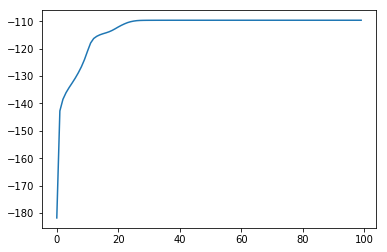

In [6]:
STATE_COUNT = 8

hmm = HMM.from_random_parameters(S=STATE_COUNT)
y,x = hmm.generate_sequence(100)

y2,x2 = hmm.generate_sequence(100)

print('original A')
print(hmm.A)
print('original B_avg')
print(hmm.B_avg)
print('original B_std')
print(hmm.B_sd)

print('original ll for the first series')
print(hmm.get_ll(y))
print('original ll for the second series')
print(hmm.get_ll(y2))


#reinitialize hmm
hmm = HMM.from_random_parameters(S=STATE_COUNT)


print('original ll for the second series for random hmm')
print(hmm.get_ll(y2))

LL = hmm.train_EM(y,EPOCH = 100)


print('original ll for the second series for trained hmm')
print(hmm.get_ll(y2))

print('learned A')
print(hmm.A)
print('learned B_avg')
print(hmm.B_avg)
print('learned B_std')
print(hmm.B_sd)
plt.plot(LL)
plt.show()

[-inf]
nan


/Users/hakansirin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
